# Fitting models to data 

A common scientific task is to formulate a mathematical model and 'fit' that model to experimental data. One of the simplest and most used ways of doing this is called 'Linear least squares regression'. It is what is usually meant when terms like  "regression", "linear regression" or "least squares" are used.

In the least squares method, we have a mathematical model, defined with a number of parameters, and some data points. As an example, a simple model (straight line) would be "y=mx + c" which has 2 parameters 'm' (the slope or gradienat of the line) and 'c' (the intercept. 

The regression process is one of optmising the 'fit' of the line to the data by establishing the 'best' values for the parameters that minimises the sum of the squared distances, or deviations, between the data and the model.

In this notebook, we'll explore how to do this using some of the fitting tools and functions available with Python.

We'll do all the imports and other housekeeping we need here before moving on


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# These 2 lines just allow 'pretty' printing of pandas stuff - non-essential
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## 1. The data

For the purposes of the next few sections of this notebook, a file with data is provided. This looks like typical experimental data that might be modeled with a straight line. There are 4 columns - 'xdat' and 'ydat', which are the x and y values, and 'xerr' and 'yerr' which are the estimated uncertainties or errors on the x and y data points.

First, we'll read in the data and make a rough plot.


,xdat,ydat,xerr,yerr
0,3.10,8.10,0.20,1.4
1,3.45,8.35,0.10,0.4
2,3.75,9.85,0.50,0.3
3,5.00,10.75,0.85,0.2
4,4.65,12.55,0.70,1.1


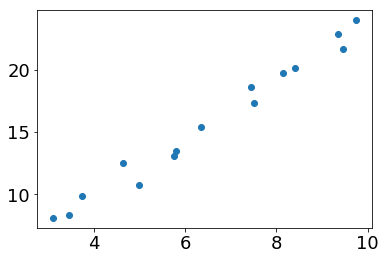

In [54]:
# Read in the data
df = pd.read_csv('line_data.csv')

# What does it look like? - just for info
df.head()

# Set up x and y - not strictly necessary, but convenient
x=df['xdat']
y=df['ydat']
y0=y

plt.scatter(x,y)

##  2. Simple regression - scipy linregress()

So, that looks like a straight line might fit - and we can do that simply by using scipy.stats.linregress()

This gives us a least squares fit, returning the slope, intercept, rvalue, pvalue and a standard error. The rvaluesquared tells you something about the 'goodness' of the fit - the closer to 1 the better.


Gradient is 2.3, Intercept is 0.4 and standard error is 0.09


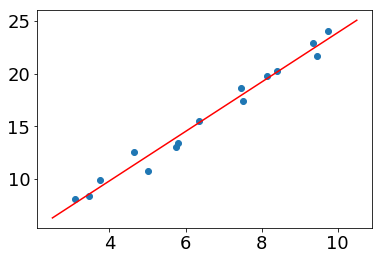

In [40]:
from scipy.stats import linregress

m,c,r_val,p_val,sterr = linregress(x,y)

print(f'Gradient is {m:.1f}, Intercept is {c:.1f} and standard error is {sterr:.2f}')

# Plot the line on to the data:
plt.scatter(x,y)
xlin = np.linspace(2.5,10.5,50)
plt.plot(xlin,(m*xlin+c), color='red')

## 3. What if we have estimated uncertainties on the y axis?

However, experimantal data often has estimates of how uncertain the measurement is - it has associated errors. 

Now, functions like linregress() treat all data points as equal. However, it's reasonable to suppose that data points with small errors should be 'weighted' much more heavily that those with large estimated errors. Luckily there are algorithms that do just that.

Here we use scipy.optimize.curve_fit() to utilise the error estimates in y that we have in the data

This is a much more general function that linregress() and allows you to define the model that you want to fit - you are not constrained to a straight line). Now in this case, we do actually want a straight line but we'll need to define it - in a specific manner using a function.

The function takes the model function you define, x and y as well as y errors. (the absolute_sigma=True tells the function we are passing it absolute errors).

It returs 2 objects, one containing the optimised parameters to the model and an covariance matrix that contains quite a bit of statistical data. We can use this statistical data to get esimates of how accurate the returned gradient and intercept are:

<ErrorbarContainer object of 3 artists>

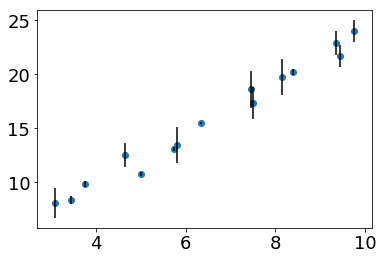

In [58]:
from scipy.optimize import curve_fit

# First get some y error from the DataFrame we've already read in
yerror = df['yerr']

# Plot it - with error bars
plt.errorbar(x, y, yerr=yerror, xerr=0, hold=True, ecolor='k', fmt='none')
plt.scatter(x,y)


In [49]:
# Define a simple, straight line model, accepting an x value or 1D array and using 
# gradient and intercept parameters:
def stLineFit(x, m, c):
    return (m*x + c)

# Call the fitting function
popt, pcov = curve_fit(stLineFit, x, y, sigma=yerror, absolute_sigma=True)
# Calculate the 'accuracy' of the returned parameters
perr = np.sqrt(np.diag(pcov)) # error values are on the covariance matrix diagonal

#print fit parameters and 1-sigma estimates
print('fit parameter 1-sigma error')
print('***************************************************')
print (f'm = {popt[0]:.2f} +- {perr[0]:.2f}')
print (f'c = {popt[1]:.2f} +- {perr[1]:.2f}')
print('***************************************************')


fit parameter 1-sigma error
***************************************************
m = 2.48 +- 0.06
c = -0.57 +- 0.39
***************************************************


### 3.1 Confidence bounds or limits

You could now go on to just plot this new estimated line as before.

However, as you can see, we have more information about uncertainties in the gradient and the intercept and we could use this information to show a set of 'confidence' bound around it.

First calculate these bound lines

In [50]:
# prepare confidence level line limits
nstd = 1.0 # to draw 1 sigma interval
# Note, remember these are numpy arrays
popt_up = popt + nstd*perr
popt_dw = popt - nstd*perr

# Get the fitted line
fit = stLineFit(x, *popt)
# Add and subtract error values
fit_up = stLineFit(x, *popt_up)
fit_dw = stLineFit(x, *popt_dw)



Now plot it

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'x')

Text(0, 0.5, 'y')

Text(0.5, 1.0, 'x Vs y with best fit line and 1 sigma confidence')

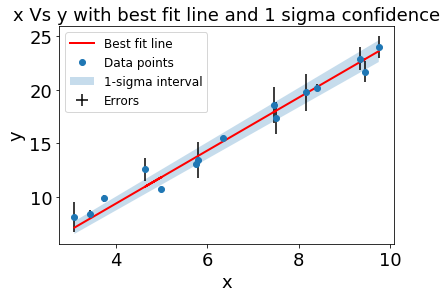

In [51]:
fig, ax = plt.subplots(1)
# Set plot parameters
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['font.size']= 20
plt.errorbar(x, y, yerr=yerror, xerr=0, hold=True, ecolor='k', fmt='none', label='Errors')

plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.title('x Vs y with best fit line and 1 sigma confidence', fontsize=18)
plt.plot(x, fit, 'r', lw=2, label='Best fit line')
plt.plot(x, y0, 'o', lw=2, label='Data points')
ax.fill_between(x, fit_up, fit_dw, alpha=.25, label='1-sigma interval')
plt.legend(loc='upper left',fontsize=12)
plt.show()

## 4. X and Y errors

Linear regression tries to minimise the sum of the squares of the 'error'. In 'usual' use (as in curve_fit), the error is the 'y' value residual measured to the fitted line. This is fine unless we have errors in both y AND x. In this case it is better to use the orthoganal distance from the data point to the fitted line - Orthogonal Distance Regression (ODR). So, here we use the scipy odr() function.


fit parameter 1-sigma error
***************************************************
m = 2.40 +- 0.05
c = 0.12 +- 0.33
***************************************************


<ErrorbarContainer object of 3 artists>

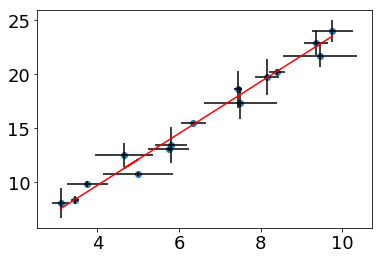

In [60]:
from scipy import odr

# Just a simple function to return a straight line for use in ODR.
# BUT, note that it is defined in a slightly different way to 'curve_fit()'
# You pass it a list/tuple of parameters and 'x' comes at the end - not first
def stLine(p,x):
    # 'p' is alist containing 'm' and 'c'
    m,c = p
    return m * x  + c

# We also need the x errors
xerror=df['xerr']

# Need to use scipy 'odr' model for fitting. 
model = odr.Model(stLine)
# Form an odr 'RealData' object
rdata = odr.RealData(x,y,sx=xerror,sy=yerror)
# Now set up the ODR, 
# We need an initial 'guess' of m and c - beta0 
# We could 'hard wire' this but as we now we are looking at a straight line,
# we'll use scipy.stats.linregress() to get an estimate.
# We need the first 2 elemts returnes which are slope and intercept (m and c)
init_guess = linregress(x,y)[0:2]
odr=odr.ODR(rdata, model, beta0=init_guess )

# Run it and get the results
result_outputs = odr.run()

# Extract the data we need
popt= result_outputs.beta
perr= result_outputs.sd_beta

#print fit parameters and 1-sigma estimates
print('fit parameter 1-sigma error')
print('***************************************************')
print (f'm = {popt[0]:.2f} +- {perr[0]:.2f}')
print (f'c = {popt[1]:.2f} +- {perr[1]:.2f}')
print('***************************************************')

# Now plot the data and fitted line:
plt.scatter(x,y)
plt.errorbar(x, y, yerr=yerror, xerr=xerror, hold=True, ecolor='k', fmt='none')
plt.plot(x, stLine((popt[0], popt[1]),x), color='red')


## 5. Using other models

the scipy 'curve_fit()' and 'odr()' functions allow you to define pretty much any model you want to fit your data.

As an example - and this will definitely prove useful later, a 'Gaussian' can be defined using 3 parameters:

$$a*np.exp(-(x-x0)**2/(2*sigma**2))$$

Where a is its amplitude, x0 it's position on the x axis, and sigma a measure of it's width.
